In [12]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm
from reskit.norms import spectral_norm, wbysqdist

from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

import matrix_eig as me

from matplotlib import pyplot as plt
%matplotlib inline
import re

In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict

In [3]:
params = {
    'text.usetex'         : True,
    'text.latex.unicode'  : True,
    'text.latex.preamble' : r"\usepackage[T2A]{fontenc}",
    'font.size'           : 15,
    'font.family'         : 'lmodern'
    }

plt.rcParams.update(params)



def print_boxplot(file_name, mod, figsize = (10.5,6.5)):
    ##################################################################
    # Paramatrs:                                                     #
    #----------------------------------------------------------------#
    # file_name: string, name of file witch has a table with columns:# 
    #           'eval_roc_auc_scores' and 'Featurizers'              #
    #                                                                #
    # mod: string, additional information for boxplot                #
    #                                                                #
    # figsize: w,h tuple in inches                                   #
    ##################################################################
    data = []
    result = pd.read_csv(file_name, index_col=0)
    
    lables          = result['Featurizers']
    array_of_arrays = result['eval_roc_auc_scores']
    for tmp in array_of_arrays:
        array_str = re.split('[]*[ ,]', tmp)
        ##########################################
        #Костыль
        for i in range(array_str.count('')):
            array_str.remove('')
        ##########################################
        array_fold = []
        for i in array_str:
            array_fold.append(float(i))
        data.append(array_fold)
        
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    bp  = ax.boxplot(data, 0, '+', labels=lables)
    
    plt.setp(bp['boxes'],    color='DarkGreen')
    plt.setp(bp['whiskers'], color='DarkOrange', linestyle = '-')
    plt.setp(bp['medians'],  color='DarkBlue')
    plt.setp(bp['caps'],     color='Gray')
    
    
    ax.set_title(r'ROC AUC mean for LogisticRegression (' + mod + ').' )
    ax.set_ylabel(r'ROC AUC mean')
    ax.set_xlabel(r'k')
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    
    plt.show()

## Train LogRegression and conctrsuct BoxPlot

In [4]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

In [26]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('binar', Transformer(binar_norm))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR


In [27]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/binar_eig_noabs_rand.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR,0.553014,0.110393,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.552595,0.0314036,"[0.46853625170998636, 0.53100775193798444, 0.5..."
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR,0.536702,0.155052,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.489827,0.0164637,"[0.48039215686274511, 0.48404012767897853, 0.5..."
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR,0.548759,0.226903,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.479539,0.0191994,"[0.48039215686274511, 0.46260829913360696, 0.5..."
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR,0.661702,0.165643,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.58606,0.0493214,"[0.60693114455084363, 0.54081167350661197, 0.5..."
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR,0.65656,0.19105,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.575942,0.0431319,"[0.5738714090287278, 0.50341997264021887, 0.48..."
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR,0.649291,0.167507,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.60782,0.0399551,"[0.57751937984496116, 0.59279525763793894, 0.5..."
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR,0.662411,0.0942538,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.59979,0.0366622,"[0.54263565891472865, 0.61422708618331046, 0.5..."
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR,0.660816,0.126381,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.611997,0.0427352,"[0.59712722298221621, 0.66689466484268134, 0.5..."
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR,0.631738,0.109886,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.581993,0.0364664,"[0.58367533059735521, 0.57136342909256732, 0.4..."


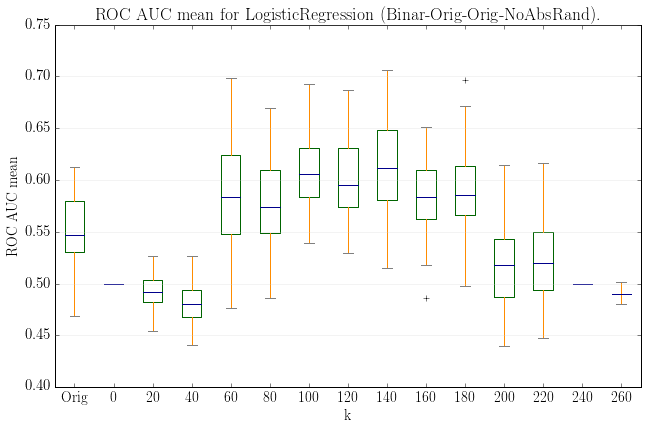

In [29]:
print_boxplot('LR/binar_eig_noabs_rand.csv', 'Binar-Orig-Orig-NoAbsRand')

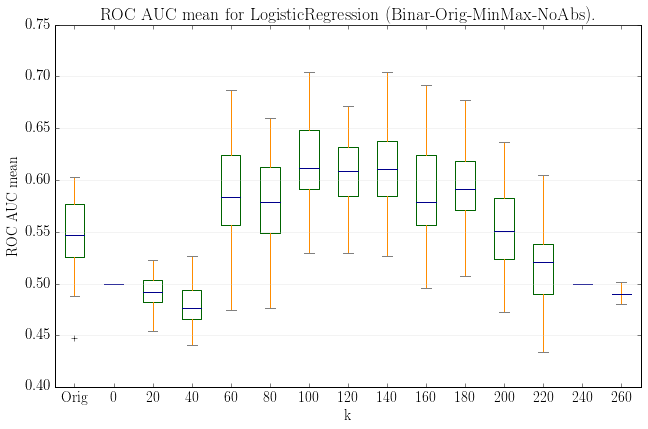

In [10]:
print_boxplot('LR/binar_eig_noabs.csv', 'Binar-Orig-MinMax-NoAbs')

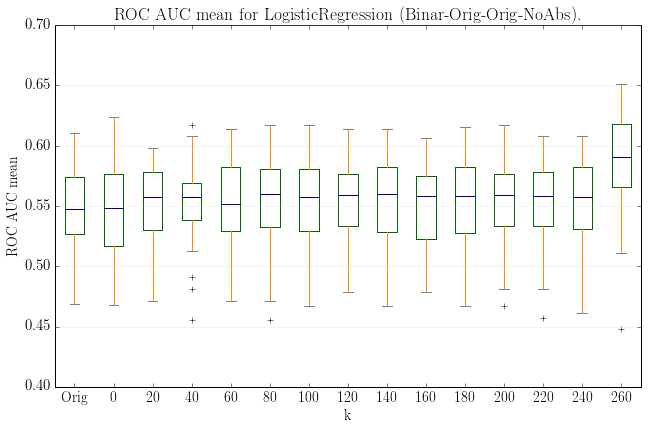

In [7]:
print_boxplot('LR/binar_eig_noabs_scal.csv', 'Binar-Orig-Orig-NoAbs')

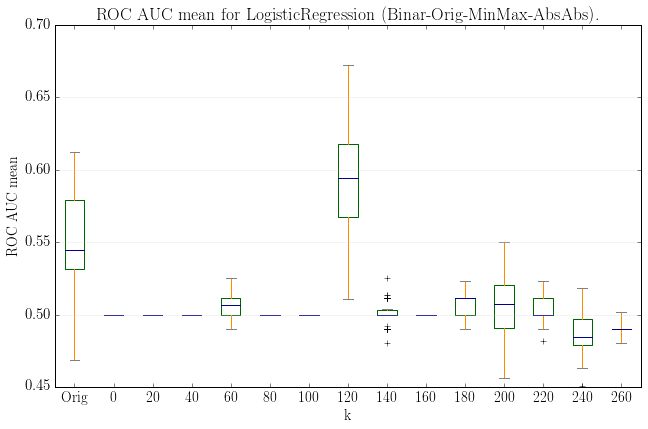

In [8]:
print_boxplot('LR/binar_eig_absabs.csv', 'Binar-Orig-MinMax-AbsAbs')

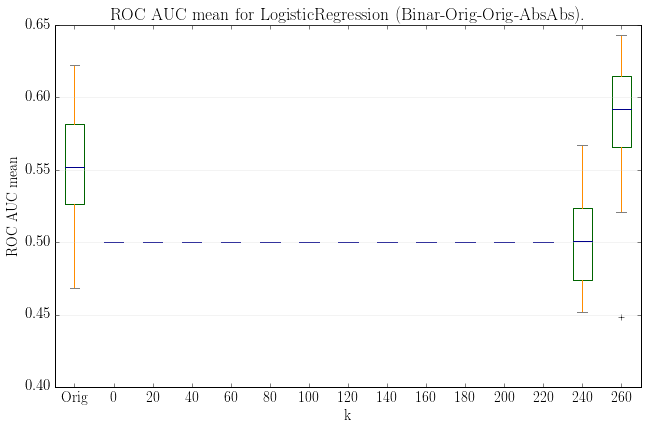

In [13]:
print_boxplot('LR/binar_eig_absabs.csv', 'Binar-Orig-Orig-AbsAbs')

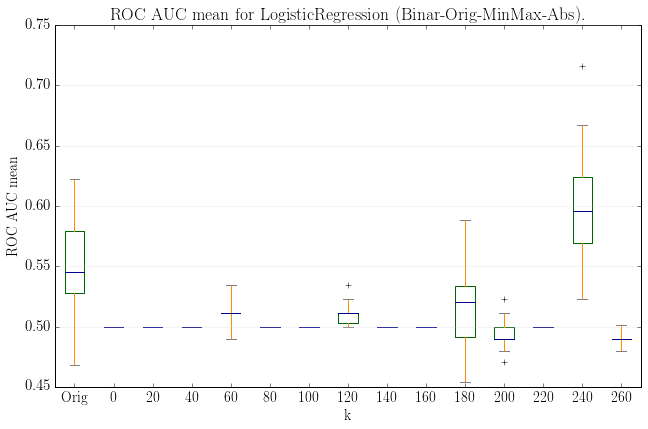

In [9]:
print_boxplot('LR/binar_eig_abs.csv', 'Binar-Orig-MinMax-Abs')

In [ ]:
#vecs noabs

In [5]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('binar', Transformer(binar_norm))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_vec1_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_vec1_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_vec1_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_vec1_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_vec1_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_vec1_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_vec1_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_vec1_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_vec1_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_vec1_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_vec1_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_vec1_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_vec1_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_vec1_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR


In [6]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/binar_vec_noabs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR,0.548759,0.110186,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.550844,0.031256,"[0.46853625170998636, 0.52918376652986776, 0.5..."
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR,0.512234,0.148805,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.523703,0.0431581,"[0.52918376652986776, 0.4630642954856361, 0.58..."
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR,0.533333,0.161227,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.520648,0.0462975,"[0.52006383948928403, 0.4630642954856361, 0.49..."
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR,0.603191,0.174613,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 100}",0.569927,0.0514639,"[0.62653898768809846, 0.59712722298221621, 0.5..."
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR,0.533511,0.176248,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.531628,0.038611,"[0.54081167350661197, 0.48198814409484725, 0.4..."
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR,0.530142,0.178493,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.568427,0.0456724,"[0.56224350205198359, 0.53465572275421791, 0.5..."
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR,0.571277,0.128347,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.53699,0.0353725,"[0.54263565891472865, 0.54810761513907891, 0.4..."
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR,0.544681,0.141472,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.553725,0.0349273,"[0.55061559507523938, 0.53032375740994075, 0.4..."
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR,0.579965,0.0874981,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.564902,0.0374119,"[0.59347925216598263, 0.55608755129958953, 0.4..."


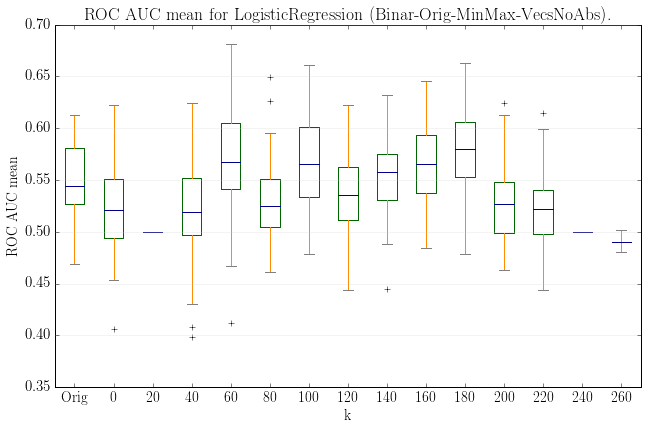

In [7]:
print_boxplot('LR/binar_vec_noabs.csv', 'Binar-Orig-MinMax-VecsNoAbs')

In [8]:
#Vecs Abs

In [9]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('binar', Transformer(binar_norm))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_vec2_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_vec2_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_vec2_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_vec2_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_vec2_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_vec2_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_vec2_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_vec2_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_vec2_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_vec2_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_vec2_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_vec2_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_vec2_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_vec2_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR


In [10]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/binar_vec_abs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR,0.557801,0.111239,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 100}",0.550524,0.0334968,"[0.46853625170998636, 0.54081167350661197, 0.5..."
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR,0.512411,0.146632,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.518026,0.0426255,"[0.51755585955312355, 0.48632010943912451, 0.5..."
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR,0.587234,0.143463,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.480611,0.0383935,"[0.4943000455996352, 0.44961240310077516, 0.46..."
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR,0.607624,0.16751,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.483192,0.0483049,"[0.44710442316461463, 0.45143638850889189, 0.4..."
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR,0.657979,0.130446,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.581619,0.0311867,"[0.59051527587779296, 0.58800729594163248, 0.6..."
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR,0.5,0,"{'penalty': 'l1', 'C': 0.01, 'max_iter': 50}",0.5,0,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR,0.511702,0.165932,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.496379,0.0101355,"[0.50182398540811679, 0.49019607843137253, 0.5..."


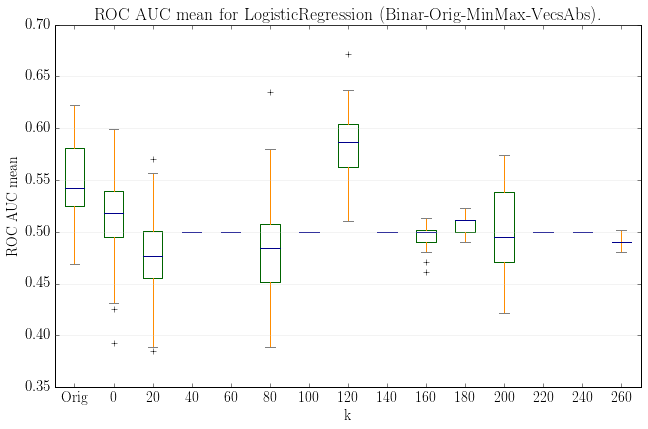

In [11]:
print_boxplot('LR/binar_vec_abs.csv', 'Binar-Orig-MinMax-VecsAbs')

In [ ]:
#WB Spectral

In [13]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('wbysqdist', Transformer(wbysqdist))]

normalizers = [('spectral', Transformer(spectral_norm))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig1_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig1_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig1_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig1_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig1_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig1_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig1_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig1_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig1_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig1_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig1_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig1_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig1_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig1_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1', 'l2']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,wbysqdist,spectral,Orig,var_threshold,minmax,LR
1,UCLAsource,wbysqdist,spectral,0,var_threshold,minmax,LR
2,UCLAsource,wbysqdist,spectral,20,var_threshold,minmax,LR
3,UCLAsource,wbysqdist,spectral,40,var_threshold,minmax,LR
4,UCLAsource,wbysqdist,spectral,60,var_threshold,minmax,LR
5,UCLAsource,wbysqdist,spectral,80,var_threshold,minmax,LR
6,UCLAsource,wbysqdist,spectral,100,var_threshold,minmax,LR
7,UCLAsource,wbysqdist,spectral,120,var_threshold,minmax,LR
8,UCLAsource,wbysqdist,spectral,140,var_threshold,minmax,LR
9,UCLAsource,wbysqdist,spectral,160,var_threshold,minmax,LR


In [14]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/wbys_specral_noabs.csv')

No previous results found.
Line: 1/15


reskit/norms.py:282: RuntimeWarning: invalid value encountered in divide
  weighted_X = X / dist ** 2


Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,wbysqdist,spectral,Orig,var_threshold,minmax,LR,0.564539,0.139897,"{'penalty': 'l2', 'C': 0.30000000000000004, 'm...",0.52332,0.0272993,"[0.47469220246238031, 0.5120839033287734, 0.56..."
1,UCLAsource,wbysqdist,spectral,0,var_threshold,minmax,LR,0.565248,0.14211,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 50}",0.531468,0.0399823,"[0.55608755129958953, 0.46853625170998636, 0.5..."
2,UCLAsource,wbysqdist,spectral,20,var_threshold,minmax,LR,0.58156,0.144801,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.554478,0.048186,"[0.49612403100775193, 0.50592795257637935, 0.5..."
3,UCLAsource,wbysqdist,spectral,40,var_threshold,minmax,LR,0.541312,0.104132,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.531491,0.0495498,"[0.45143638850889189, 0.48016415868673051, 0.5..."
4,UCLAsource,wbysqdist,spectral,60,var_threshold,minmax,LR,0.554965,0.181393,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.533324,0.0386514,"[0.47651618787049704, 0.45873233014135884, 0.5..."
5,UCLAsource,wbysqdist,spectral,80,var_threshold,minmax,LR,0.611702,0.13555,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 50}",0.538463,0.0369846,"[0.50957592339261293, 0.50159598723210219, 0.5..."
6,UCLAsource,wbysqdist,spectral,100,var_threshold,minmax,LR,0.585638,0.154957,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.552905,0.0344725,"[0.51937984496124034, 0.49794801641586867, 0.5..."
7,UCLAsource,wbysqdist,spectral,120,var_threshold,minmax,LR,0.559574,0.154072,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 100}",0.541541,0.0417619,"[0.49612403100775193, 0.46853625170998636, 0.5..."
8,UCLAsource,wbysqdist,spectral,140,var_threshold,minmax,LR,0.580674,0.172526,"{'penalty': 'l1', 'C': 0.7000000000000001, 'ma...",0.550698,0.0458204,"[0.50957592339261293, 0.47651618787049704, 0.5..."
9,UCLAsource,wbysqdist,spectral,160,var_threshold,minmax,LR,0.574823,0.18439,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.556357,0.042191,"[0.48814409484724119, 0.52120383036935714, 0.5..."


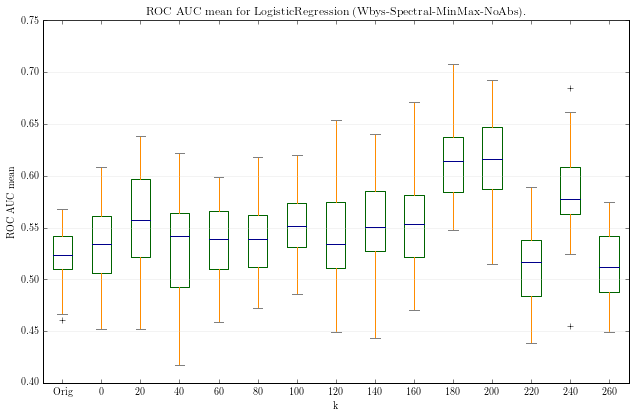

In [15]:
print_boxplot('LR/wbys_specral_noabs.csv', 'Wbys-Spectral-MinMax-NoAbs')

In [16]:
#WB Abs

In [17]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('wbysqdist', Transformer(wbysqdist))]

normalizers = [('spectral', Transformer(spectral_norm))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig2_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig2_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig2_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig2_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig2_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig2_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig2_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig2_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig2_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig2_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig2_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig2_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig2_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig2_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1', 'l2']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,wbysqdist,spectral,Orig,var_threshold,minmax,LR
1,UCLAsource,wbysqdist,spectral,0,var_threshold,minmax,LR
2,UCLAsource,wbysqdist,spectral,20,var_threshold,minmax,LR
3,UCLAsource,wbysqdist,spectral,40,var_threshold,minmax,LR
4,UCLAsource,wbysqdist,spectral,60,var_threshold,minmax,LR
5,UCLAsource,wbysqdist,spectral,80,var_threshold,minmax,LR
6,UCLAsource,wbysqdist,spectral,100,var_threshold,minmax,LR
7,UCLAsource,wbysqdist,spectral,120,var_threshold,minmax,LR
8,UCLAsource,wbysqdist,spectral,140,var_threshold,minmax,LR
9,UCLAsource,wbysqdist,spectral,160,var_threshold,minmax,LR


In [18]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/wbys_specral_abs.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,wbysqdist,spectral,Orig,var_threshold,minmax,LR,0.564539,0.139897,"{'penalty': 'l2', 'C': 0.30000000000000004, 'm...",0.52332,0.0272993,"[0.47469220246238031, 0.5120839033287734, 0.56..."
1,UCLAsource,wbysqdist,spectral,0,var_threshold,minmax,LR,0.565248,0.12413,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 50}",0.531997,0.0454567,"[0.5230278157774737, 0.47834017327861378, 0.55..."
2,UCLAsource,wbysqdist,spectral,20,var_threshold,minmax,LR,0.577837,0.156928,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.525367,0.0404515,"[0.5364797081623347, 0.48016415868673051, 0.50..."
3,UCLAsource,wbysqdist,spectral,40,var_threshold,minmax,LR,0.580674,0.144385,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 50}",0.551003,0.046987,"[0.58732330141358868, 0.50341997264021887, 0.5..."
4,UCLAsource,wbysqdist,spectral,60,var_threshold,minmax,LR,0.610993,0.166297,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.54834,0.0433518,"[0.49179206566347478, 0.50957592339261293, 0.5..."
5,UCLAsource,wbysqdist,spectral,80,var_threshold,minmax,LR,0.603723,0.141729,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 100}",0.547301,0.0442143,"[0.51322389420884629, 0.53100775193798444, 0.6..."
6,UCLAsource,wbysqdist,spectral,100,var_threshold,minmax,LR,0.531738,0.156129,"{'penalty': 'l1', 'C': 0.6000000000000001, 'ma...",0.512166,0.0408194,"[0.53465572275421791, 0.5120839033287734, 0.51..."
7,UCLAsource,wbysqdist,spectral,120,var_threshold,minmax,LR,0.584397,0.125704,"{'penalty': 'l1', 'C': 0.8, 'max_iter': 50}",0.523566,0.041636,"[0.49361605107159146, 0.4997720018239854, 0.52..."
8,UCLAsource,wbysqdist,spectral,140,var_threshold,minmax,LR,0.606028,0.173782,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 100}",0.554013,0.0396153,"[0.56589147286821706, 0.5230278157774737, 0.56..."
9,UCLAsource,wbysqdist,spectral,160,var_threshold,minmax,LR,0.613298,0.12151,"{'penalty': 'l1', 'C': 0.9, 'max_iter': 50}",0.549503,0.0491708,"[0.52667578659370728, 0.46853625170998636, 0.5..."


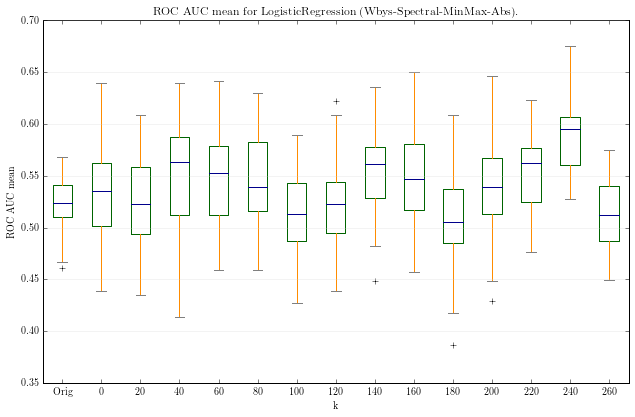

In [19]:
print_boxplot('LR/wbys_specral_abs.csv', 'Wbys-Spectral-MinMax-Abs')